# 재구매 예측

## 0. import

In [1]:
from jbfg.pandas_utils import *
import pickle
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import calendar
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

## 1. 데이터 탐색

### 1-1. products_info

In [2]:
schema = 'l2_jbbk_extnl'

In [3]:
sql = 'SELECT * FROM products_info'
df_products_info = get_df(sql, schema)
df_products_info
# df_products_info.tail()

,product_id,name,category_id,division_id,category_name,division_name
0,21709,Sparkling Lemon Water,115,7,water seltzer sparkling water,beverages
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen
2,33000,Pure Irish Butter,36,16,butter,dairy eggs
3,7781,Organic Sticks Low Moisture Part Skim Mozzarel...,21,16,packaged cheese,dairy eggs
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
...,...,...,...,...,...,...
95,47209,Organic Hass Avocado,24,4,fresh fruits,produce
96,21903,Organic Baby Spinach,123,4,packaged vegetables fruits,produce
97,21137,Organic Strawberries,24,4,fresh fruits,produce
98,13176,Bag of Organic Bananas,24,4,fresh fruits,produce


In [4]:
df_products_info['category_id'] = df_products_info['category_id'].astype(int)
df_products_info['division_id'] = df_products_info['division_id'].astype(int)
df_products_info['product_id'] = df_products_info['product_id'].astype(int)

In [5]:
df_products_info_ch = df_products_info.sort_values(by=['division_id','category_id','product_id'])
df_products_info_ch

,product_id,name,category_id,division_id,category_name,division_name
50,9076,Blueberries,116,1,frozen produce,frozen
1,20995,Organic Broccoli Florets,116,1,frozen produce,frozen
58,5077,100% Whole Wheat Bread,112,3,bread,bakery
34,28842,Bunched Cilantro,16,4,fresh herbs,produce
66,31717,Organic Cilantro,16,4,fresh herbs,produce
...,...,...,...,...,...,...
39,24838,Unsweetened Almondmilk,91,16,soy lactosefree,dairy eggs
54,35951,Organic Unsweetened Almond Milk,91,16,soy lactosefree,dairy eggs
4,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
67,30489,Original Hummus,67,20,fresh dips tapenades,deli


In [6]:
df_products_info_ch.to_csv(f'df_products_info_ch.csv', encoding='CP949')

In [7]:
pro_cnt = df_products_info_ch.groupby(['division_name'], dropna=False).agg(cnt=('name','count')).reset_index()
pro_cnt = pro_cnt.sort_values('cnt',ascending=False)
pro_cnt

,division_name,cnt
8,produce,67
3,dairy eggs,18
1,beverages,7
4,deli,2
5,frozen,2
0,bakery,1
2,canned goods,1
6,meat seafood,1
7,pantry,1


<BarContainer object of 9 artists>

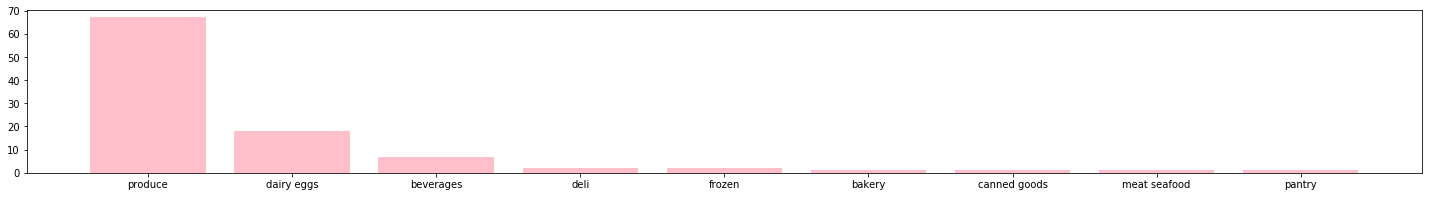

In [8]:
plt.figure(figsize=(25, 3))
plt.bar(pro_cnt['division_name'], pro_cnt['cnt'], color='pink')

In [9]:
cate_cnt = df_products_info_ch.groupby(['category_name'], dropna=False).agg(cnt=('name','count')).reset_index()
cate_cnt = cate_cnt.sort_values('cnt',ascending=False)
cate_cnt

,category_name,cnt
8,fresh vegetables,29
6,fresh fruits,24
16,packaged vegetables fruits,9
20,water seltzer sparkling water,5
11,milk,5
13,packaged cheese,4
19,soy lactosefree,3
7,fresh herbs,3
15,packaged produce,2
3,cream,2


<BarContainer object of 21 artists>

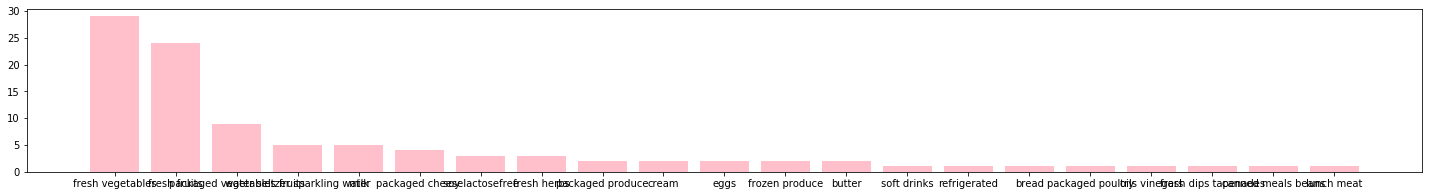

In [10]:
plt.figure(figsize=(25, 3))
plt.bar(cate_cnt['category_name'], cate_cnt['cnt'], color='pink')

## 1-2. train_x_past

In [11]:
sql = 'SELECT * FROM train_x_past'
df_train_x_past = get_df(sql, schema)
df_train_x_past.tail()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
1253967,1902783,163819,47,0,19,13.0,2,1,24852
1253968,1969590,163819,42,1,15,6.0,3,1,24852
1253969,2549215,163819,9,1,11,7.0,1,1,24852
1253970,3103211,163819,39,1,14,7.0,3,1,24852
1253971,3207262,163819,8,1,12,7.0,1,1,24852


In [12]:
df_train_x_past_ch = df_train_x_past.apply(pd.to_numeric, errors='coerce').fillna(0)

In [13]:
df_train_x_past_ch = df_train_x_past_ch.merge(df_products_info_ch, on='product_id', how='left')
df_train_x_past_ch

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,3.0,5,0,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,2.0,7,1,41220,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,2.0,11,1,4210,Whole Milk,84,16,milk,dairy eggs
3,1326515,196613,61,3,19,3.0,3,1,4210,Whole Milk,84,16,milk,dairy eggs
4,1437845,196613,36,3,15,4.0,16,0,4210,Whole Milk,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1253967,1902783,163819,47,0,19,13.0,2,1,24852,Banana,24,4,fresh fruits,produce
1253968,1969590,163819,42,1,15,6.0,3,1,24852,Banana,24,4,fresh fruits,produce
1253969,2549215,163819,9,1,11,7.0,1,1,24852,Banana,24,4,fresh fruits,produce
1253970,3103211,163819,39,1,14,7.0,3,1,24852,Banana,24,4,fresh fruits,produce


### 마스터 테이블 1 (전체거래)

In [14]:
df_train_x_past_1 = df_train_x_past_ch.sort_values(by=['cstno','order_number','add_order'])
df_train_x_past_1

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
1695,3131103,50,2,6,12,10.0,3,0,21137,Organic Strawberries,24,4,fresh fruits,produce
1676,2197066,50,3,1,13,9.0,2,0,47209,Organic Hass Avocado,24,4,fresh fruits,produce
1657,3201640,50,4,0,11,6.0,5,0,24964,Organic Garlic,83,4,fresh vegetables,produce
1613,2756806,50,5,4,14,11.0,6,0,34126,Organic Italian Parsley Bunch,16,4,fresh herbs,produce
1622,1941871,50,9,4,11,5.0,1,0,41950,Organic Tomato Cluster,83,4,fresh vegetables,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405997,355332,206124,57,1,7,10.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405992,72602,206124,58,5,15,4.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405973,1113246,206124,59,5,13,7.0,7,1,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
406005,1484260,206124,61,1,8,6.0,3,1,49235,Organic Half & Half,53,16,cream,dairy eggs


In [15]:
df_train_x_past_1.to_csv(f'df_train_x_past_1.csv', encoding='CP949')

### 마스터 테이블2 (고객별 주문번호별 (add_order 무시))

In [17]:
df_train_x_past_2 = df_train_x_past_1.drop_duplicates(['cstno','order_number'],keep='last')
df_train_x_past_2

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,name,category_id,division_id,category_name,division_name
1695,3131103,50,2,6,12,10.0,3,0,21137,Organic Strawberries,24,4,fresh fruits,produce
1676,2197066,50,3,1,13,9.0,2,0,47209,Organic Hass Avocado,24,4,fresh fruits,produce
1657,3201640,50,4,0,11,6.0,5,0,24964,Organic Garlic,83,4,fresh vegetables,produce
1613,2756806,50,5,4,14,11.0,6,0,34126,Organic Italian Parsley Bunch,16,4,fresh herbs,produce
1612,1941871,50,9,4,11,5.0,5,1,34126,Organic Italian Parsley Bunch,16,4,fresh herbs,produce
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405997,355332,206124,57,1,7,10.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405992,72602,206124,58,5,15,4.0,6,1,49235,Organic Half & Half,53,16,cream,dairy eggs
405973,1113246,206124,59,5,13,7.0,7,1,47144,Unsweetened Original Almond Breeze Almond Milk,91,16,soy lactosefree,dairy eggs
406005,1484260,206124,61,1,8,6.0,3,1,49235,Organic Half & Half,53,16,cream,dairy eggs


In [18]:
df_train_x_past_2.to_csv(f'df_train_x_past_2.csv', encoding='CP949')

### 1-2-1. 고객별 가장 주문이 많은 요일

In [19]:
df_train_x_past_ch['week_day'].value_counts()

0    233220
1    223454
5    173503
6    167028
2    157744
4    151015
3    148008
Name: week_day, dtype: int64

In [20]:
df_train_x_past_2_1 = df_train_x_past_2.groupby(['cstno','week_day'], dropna=False).agg(weekday_gu=('week_day','count')).reset_index()
df_train_x_past_2_1 = df_train_x_past_2_1.sort_values(['cstno','weekday_gu'],ascending=True)
df_train_x_past_2_1 = df_train_x_past_2_1.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_1

,cstno,week_day,weekday_gu
1,50,1,13
13,140,6,11
18,204,4,9
21,210,0,28
28,223,1,37
...,...,...,...
39068,205972,5,48
39069,205983,1,23
39075,206035,1,15
39081,206053,1,11


In [21]:
df_train_x_past_2_1 = df_train_x_past_2_1.groupby(['week_day'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_1

,week_day,cnt
0,0,1432
1,1,1381
2,2,543
3,3,485
4,4,521
5,5,723
6,6,774


<BarContainer object of 7 artists>

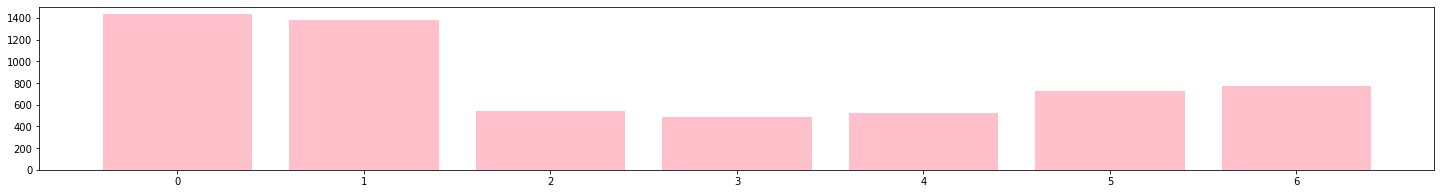

In [22]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_1['week_day'], df_train_x_past_2_1['cnt'], color='pink')

### 1-2-2. 고객별 가장 주문이 많은 시간

In [23]:
df_train_x_past_2_2 = df_train_x_past_2.groupby(['cstno','order_hour'], dropna=False).agg(order_hour_gu=('order_hour','count')).reset_index()
df_train_x_past_2_2 = df_train_x_past_2_2.sort_values(['cstno','order_hour_gu'],ascending=True)
df_train_x_past_2_2 = df_train_x_past_2_2.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_2

,cstno,order_hour,order_hour_gu
4,50,11,13
14,140,10,11
30,204,10,7
56,210,17,11
63,223,8,19
...,...,...,...
83381,205972,11,17
83390,205983,8,34
83400,206035,10,11
83414,206053,16,14


In [25]:
# df_train_x_past_2_2 = df_train_x_past_2_2.groupby(['order_hour'], dropna=False).agg(cnt=('cstno','count')).reset_index()
# df_train_x_past_2_2

<BarContainer object of 23 artists>

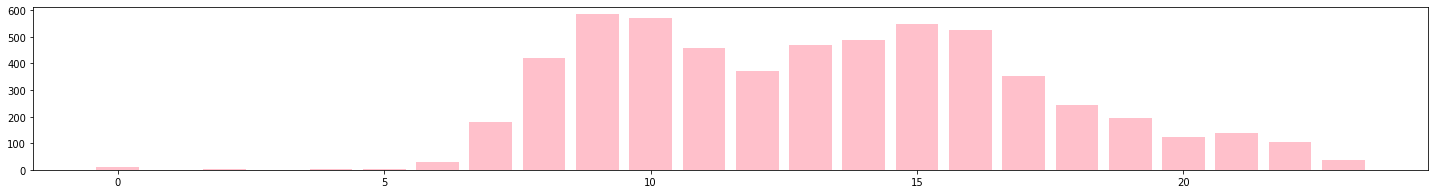

In [26]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_2['order_hour'], df_train_x_past_2_2['cnt'], color='pink')

### 1-2-3. 고객별 가장 많은 주문간격

In [27]:
df_train_x_past_2_3 = df_train_x_past_2.groupby(['cstno','order_interval'], dropna=False).agg(order_interval_gu=('order_interval','count')).reset_index()
df_train_x_past_2_3 = df_train_x_past_2_3.sort_values(['cstno','order_interval_gu'],ascending=True)
df_train_x_past_2_3 = df_train_x_past_2_3.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_3

,cstno,order_interval,order_interval_gu
4,50,5.0,10
18,140,5.0,16
31,204,4.0,12
46,210,3.0,36
57,223,7.0,28
...,...,...,...
77049,205972,0.0,36
77063,205983,1.0,16
77077,206035,3.0,9
77094,206053,4.0,12


In [28]:
# df_train_x_past_2_3 = df_train_x_past_2_3.groupby(['order_interval'], dropna=False).agg(cnt=('cstno','count')).reset_index()
# df_train_x_past_2_3

<BarContainer object of 13 artists>

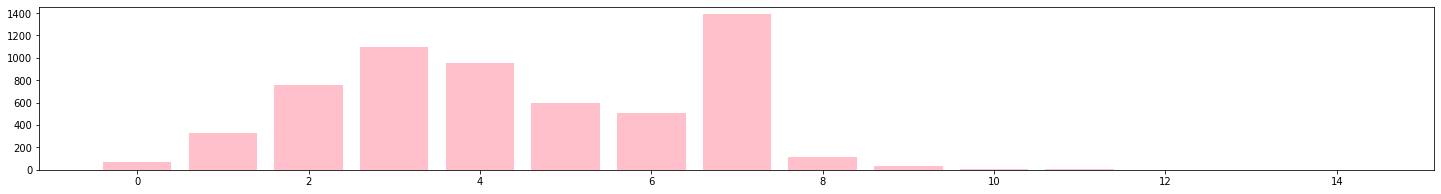

In [29]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_3['order_interval'], df_train_x_past_2_3['cnt'], color='pink')

In [30]:
df_train_x_past_2_3_2 = df_train_x_past_2.groupby(['order_interval','name'], dropna=False).agg(pro_cnt=('name','count')).reset_index()

In [31]:
df_train_x_past_2_3_2 = df_train_x_past_2_3_2.sort_values(['order_interval','pro_cnt'],ascending=True)
df_train_x_past_2_3_2 = df_train_x_past_2_3_2.drop_duplicates(['order_interval'],keep='last')
df_train_x_past_2_3_2

,order_interval,name,pro_cnt
6,0.0,Banana,782
106,1.0,Banana,1327
205,2.0,Bag of Organic Bananas,2372
305,3.0,Bag of Organic Bananas,2650
405,4.0,Bag of Organic Bananas,2322
506,5.0,Banana,1868
606,6.0,Banana,1730
706,7.0,Banana,2130
806,8.0,Banana,918
906,9.0,Banana,456


In [32]:
df_train_x_past_2_3_3 = df_train_x_past_2.groupby(['cstno','order_interval','name'], dropna=False).agg(pro_cnt=('name','count')).reset_index()
df_train_x_past_2_3_3 = df_train_x_past_2_3_3.sort_values(['cstno','order_interval','pro_cnt'],ascending=True)
# df_train_x_past_2_3_3 = df_train_x_past_2_3_3.drop_duplicates(['order_interval'],keep='last')
df_train_x_past_2_3_3

,cstno,order_interval,name,pro_cnt
0,50,1.0,Organic Lemon,1
1,50,1.0,Organic Yellow Onion,1
2,50,2.0,Organic Carrot Bunch,1
3,50,2.0,Organic Hass Avocado,1
4,50,2.0,Organic Lemon,1
...,...,...,...,...
257692,206124,11.0,Organic Half & Half,1
257693,206124,12.0,Banana,1
257694,206124,14.0,Organic Half & Half,1
257695,206124,15.0,Organic Half & Half,1


### 1-2-4. 고객별 가장 주문이 많은 상품

In [33]:
df_train_x_past_2_4 = df_train_x_past_1.groupby(['cstno','product_id','name'], dropna=False).agg(product_gu=('product_id','count')).reset_index()
df_train_x_past_2_4 = df_train_x_past_2_4.sort_values(['cstno','product_gu'],ascending=True)
df_train_x_past_2_4 = df_train_x_past_2_4.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_4

,cstno,product_id,name,product_gu
16,50,41950,Organic Tomato Cluster,19
32,140,19057,Organic Large Extra Fancy Fuji Apple,25
70,204,13176,Bag of Organic Bananas,23
115,210,23909,2% Reduced Fat Milk,79
161,223,27086,Half & Half,20
...,...,...,...,...
170087,205972,44632,Sparkling Water Grapefruit,71
170094,205983,24852,Banana,55
170121,206035,24852,Banana,32
170167,206053,24838,Unsweetened Almondmilk,30


In [34]:
df_train_x_past_2_4 = df_train_x_past_2_4.groupby(['product_id','name'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_4 = df_train_x_past_2_4.sort_values('cnt',ascending=False).head(10)
df_train_x_past_2_4

,product_id,name,cnt
42,24852,Banana,1134
21,13176,Bag of Organic Bananas,840
52,27845,Organic Whole Milk,308
94,47209,Organic Hass Avocado,253
31,21137,Organic Strawberries,222
34,21903,Organic Baby Spinach,181
96,47766,Organic Avocado,155
53,27966,Organic Raspberries,133
28,19660,Spring Water,118
98,49235,Organic Half & Half,103


<BarContainer object of 10 artists>

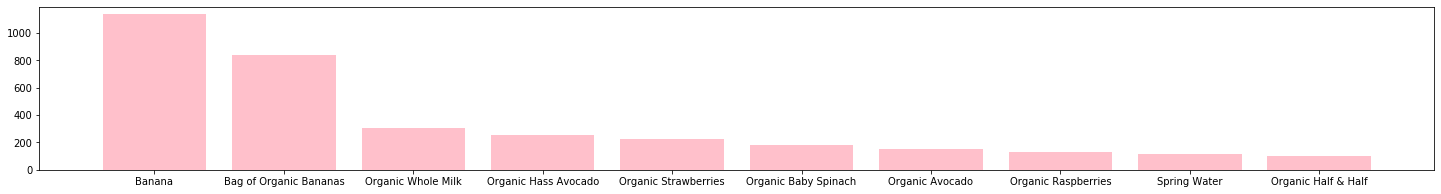

In [35]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_4['name'], df_train_x_past_2_4['cnt'], color='pink')

### 1-2-5. 고객별 구매횟수 구간

In [36]:
df_train_x_past_2_5 = df_train_x_past_2[['cstno','order_number']]
df_train_x_past_2_5 = df_train_x_past_2_5.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_5 = df_train_x_past_2_5.groupby(['order_number'], dropna=False).agg(cnt=('cstno','count')).reset_index()

In [37]:
df_train_x_past_2_5 = df_train_x_past_2[['cstno','order_number']]
df_train_x_past_2_5 = df_train_x_past_2_5.groupby(['cstno'], dropna=False).agg(cnt=('order_number','count')).reset_index()
df_train_x_past_2_5

,cstno,cnt
0,50,51
1,140,68
2,204,50
3,210,98
4,223,42
...,...,...
5854,205972,97
5855,205983,79
5856,206035,56
5857,206053,56


In [38]:
df_train_x_past_2_5 = df_train_x_past_2_5.groupby(['cnt'], dropna=False).agg(order_cnt=('cstno','count')).reset_index()
df_train_x_past_2_5.tail()

,cnt,order_cnt
53,95,29
54,96,25
55,97,30
56,98,15
57,99,24


<BarContainer object of 58 artists>

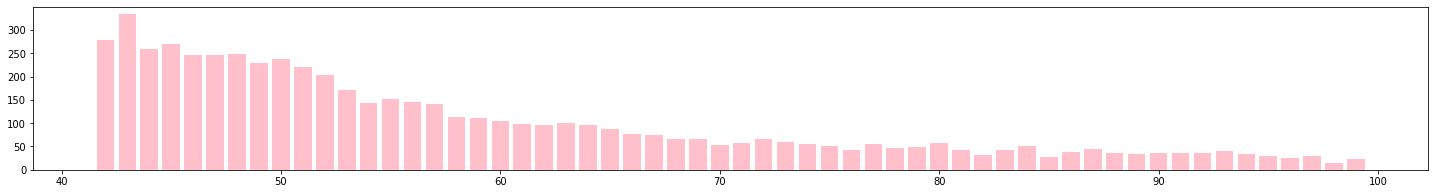

In [39]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_5['cnt'], df_train_x_past_2_5['order_cnt'], color='pink')

### 1-2-6. 고객별 거래기간

In [40]:
df_train_x_past_2_6 = df_train_x_past_2.drop_duplicates(['cstno','order_id'],keep='last')
df_train_x_past_2_6 = df_train_x_past_2_6.groupby(['cstno'], dropna=False).agg(period=('order_interval','sum')).reset_index()
df_train_x_past_2_6 = df_train_x_past_2_6.groupby(['period'], dropna=False).agg(period_cnt=('cstno','count')).reset_index()
df_train_x_past_2_6

,period,period_cnt
0,16.0,1
1,19.0,1
2,47.0,1
3,52.0,1
4,54.0,3
...,...,...
264,360.0,34
265,361.0,24
266,362.0,21
267,363.0,8


<BarContainer object of 269 artists>

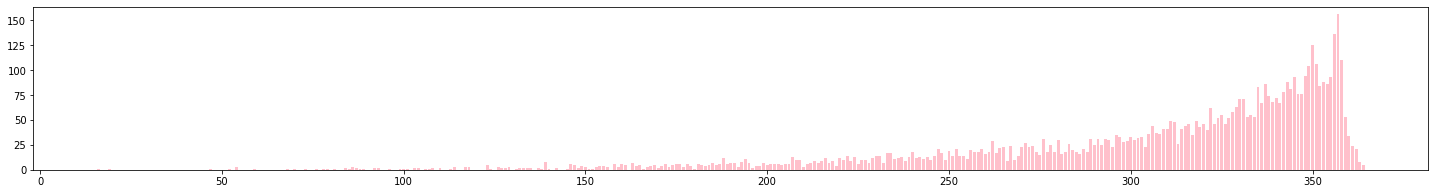

In [41]:
# 거래기간 일수 기준
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_6['period'], df_train_x_past_2_6['period_cnt'],color='pink')

In [42]:
# 거래기간 월수 기준
df_train_x_past_2_6['period_m'] = round(df_train_x_past_2_6['period']/30)
df_train_x_past_2_6

,period,period_cnt,period_m
0,16.0,1,1.0
1,19.0,1,1.0
2,47.0,1,2.0
3,52.0,1,2.0
4,54.0,3,2.0
...,...,...,...
264,360.0,34,12.0
265,361.0,24,12.0
266,362.0,21,12.0
267,363.0,8,12.0


<BarContainer object of 269 artists>

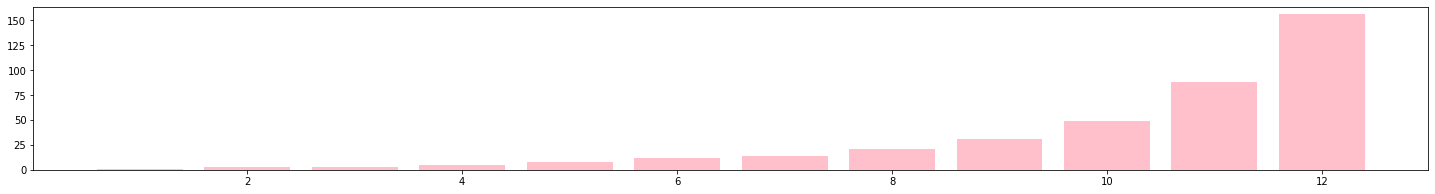

In [43]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_6['period_m'], df_train_x_past_2_6['period_cnt'],color='pink')

### 1-2-7. 고객별 가장 많이 재구매한 상품

In [44]:
df_train_x_past_2_7 = df_train_x_past_1.groupby(['cstno','name'], dropna=False).agg(re_gu=('is_reordered','count')).reset_index()
df_train_x_past_2_7 = df_train_x_past_2_7.sort_values(['cstno','re_gu'],ascending=True)
df_train_x_past_2_7 = df_train_x_past_2_7.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_7

,cstno,name,re_gu
18,50,Organic Tomato Cluster,19
51,140,Organic Large Extra Fancy Fuji Apple,25
67,204,Bag of Organic Bananas,23
96,210,2% Reduced Fat Milk,79
150,223,Half & Half,20
...,...,...,...
170088,205972,Sparkling Water Grapefruit,71
170091,205983,Banana,55
170104,206035,Banana,32
170186,206053,Unsweetened Almondmilk,30


In [45]:
df_train_x_past_2_7 = df_train_x_past_2_7.groupby(['name'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_7 = df_train_x_past_2_7.sort_values('cnt',ascending=False).head(10)
df_train_x_past_2_7

,name,cnt
6,Banana,1120
5,Bag of Organic Bananas,832
74,Organic Whole Milk,316
71,Organic Strawberries,243
55,Organic Hass Avocado,242
35,Organic Baby Spinach,177
32,Organic Avocado,146
63,Organic Raspberries,128
92,Spring Water,119
67,Organic Reduced Fat Milk,100


<BarContainer object of 10 artists>

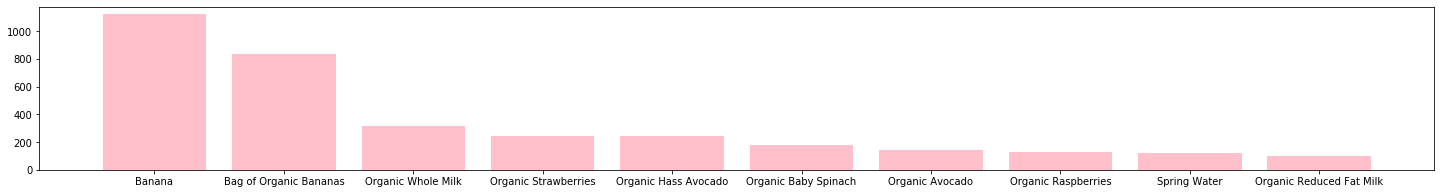

In [46]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_7['name'], df_train_x_past_2_7['cnt'],color='pink')

### 1-2-8. 고객별 한번에 구매하는 상품개수

In [47]:
df_train_x_past_2_8 = df_train_x_past_1.groupby(['cstno','order_number'], dropna=False).agg(cnt_prod=('product_id','count')).reset_index()
df_train_x_past_2_8 = df_train_x_past_2_8.sort_values(['cstno','cnt_prod'],ascending=True)
df_train_x_past_2_8 = df_train_x_past_2_8.drop_duplicates(['cstno'],keep='last')
df_train_x_past_2_8

,cstno,order_number,cnt_prod
43,50,60,7
67,140,20,14
161,204,50,6
244,210,77,12
304,223,43,10
...,...,...,...
341367,205972,22,9
341492,205983,51,6
341570,206035,49,14
341602,206053,26,14


In [48]:
df_train_x_past_2_8 = df_train_x_past_2_8.groupby(['cnt_prod'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_8

,cnt_prod,cnt
0,1,16
1,2,52
2,3,157
3,4,311
4,5,448
5,6,568
6,7,679
7,8,682
8,9,661
9,10,560


<BarContainer object of 25 artists>

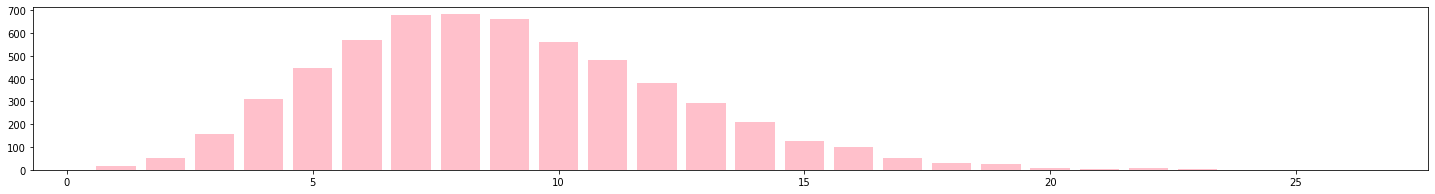

In [49]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_8['cnt_prod'], df_train_x_past_2_8['cnt'], color='pink')

In [50]:
df_train_x_past_2_8 = df_train_x_past_1.groupby(['cstno','order_number'], dropna=False).agg(cnt_prod=('product_id','count')).reset_index()
df_train_x_past_2_8 = df_train_x_past_2_8.sort_values(['cstno','cnt_prod'],ascending=True)
df_train_x_past_2_8

,cstno,order_number,cnt_prod
0,50,2,1
1,50,3,1
2,50,4,1
3,50,5,1
5,50,10,1
...,...,...,...
341644,206124,18,3
341653,206124,33,3
341637,206124,5,4
341638,206124,6,4


In [51]:
df_train_x_past_2_8 = df_train_x_past_2_8.groupby(['cnt_prod'], dropna=False).agg(cnt=('cstno','count')).reset_index()
df_train_x_past_2_8

,cnt_prod,cnt
0,1,69375
1,2,69006
2,3,58138
3,4,44109
4,5,32559
5,6,23056
6,7,15920
7,8,10816
8,9,7172
9,10,4454


<BarContainer object of 25 artists>

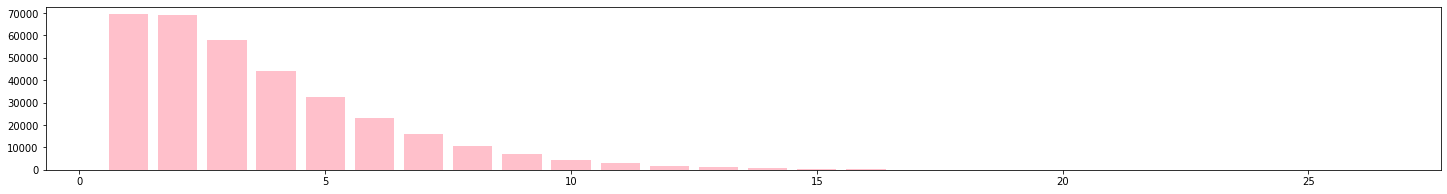

In [52]:
plt.figure(figsize=(25, 3))
plt.bar(df_train_x_past_2_8['cnt_prod'], df_train_x_past_2_8['cnt'], color='pink')